# Learning Objectives of the LSTM tutorial:
* Build a simple LSTM 
* Become familiar with PyTorch
* Train models using GPU
* Use cloud hosted data (via AWS S3 -  streamflow-app-data bucket)


In [1]:
#basic packages
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# import numpy as np

#modeling packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

#Modeling scripts from scripts folder
from scripts.LSTM import Simple_LSTM, train_LSTM, LSTM_load
from scripts.dataprocessing import readdata, df_combine, Multivariate_DataProcessing
from scripts.evaluation import plot, model_eval, Models_Eval_plot

#See if you system is using GPU (cuda) or cpu. We want to run on cpu if possible
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")



Using device: cuda


## Making a real model!
This tutorial will use USGS NWIS 10155000 in Charelston, UT to demonstrate the development of a real world modeling pipeline.
We will:
* load the daily streamflow from the CIROH AWS S3 streamflow-app-data bucket in .parquet format
* process it for use in the LSTM
* use a prebuilt LSTM from [LSTM.py](/scripts/LSTM.py) to train, test, and evaluate the model

![site](Images/10155000site.JPG)

Using the [Community Streamflow Evaluation System (CSES)](http://portal.ciroh.org/t/apps/community-streamflow-evaluation-system/huc_eval/?), we find that the NWM NHDPlus id for this USGS location is 10375648.

In [2]:
#read parquet file from AWS s3 - put in credentials or updated script to not need them
folder = 'RJ/data'
USGSpath = f"{folder}/GSL_NWM_NWIS_dataset.parquet"

df = readdata(USGSpath, drop = True)

#change column name for USGS flow
df.rename(columns={'flow_cfs': 'USGS_flow'}, inplace= True)

#select our site of interest
NWISsite = 10155000
df = df[df['station_id'] == NWISsite]

#selecting dynamic columns for use as features into the model
cols = ['datetime','DOY', 's1', 's2', 'storage', 'swe', 'NWM_flow', 'USGS_flow']
df=df[cols]

#convert datetime to pandas datetime dtype
df['datetime'] =pd.to_datetime(df['datetime'])

#sort values and set index to date time
df.sort_values(by='datetime', inplace=True)
df.set_index('datetime', inplace=True)

#drop any rows with NaN
df = df.dropna()

df.head(5)

,DOY,s1,s2,storage,swe,NWM_flow,USGS_flow
datetime,,,,,,,
1986-10-01,274,-0.891007,-0.453991,0.0,1.5,167.0,144.11765
1986-10-02,275,-0.891007,-0.453991,0.0,1.8,166.0,147.25000
1986-10-03,276,-0.891007,-0.453991,0.0,1.7,166.0,154.50000
1986-10-04,277,-0.891007,-0.453991,0.0,1.4,166.0,144.12500
1986-10-05,278,-0.891007,-0.453991,0.0,1.5,165.0,142.50000


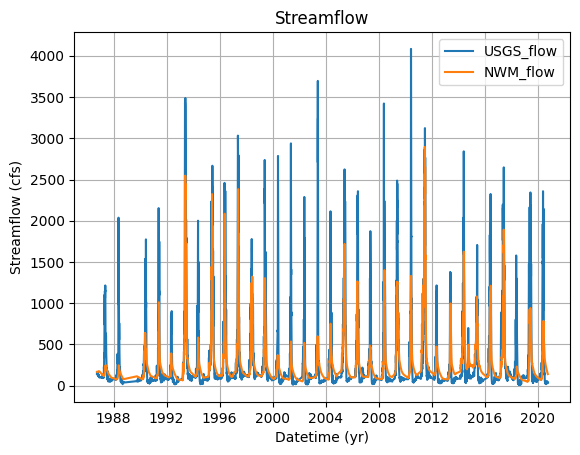

In [3]:
#plot the data
cols = ['USGS_flow', 'NWM_flow']
plot(df, cols)

## What do we observe?
We see the NWM consistently overestimating flow for this location, can we build an LSTM to correct the flows?

## Use the NWM as a feature input and use the LSTM to correct the flows
We want to add feature inputs into the LSTM and train the neural network to "fix" the NWM model outputs to the target USGS gauge location.

We typically perform simple time series prediction on a moving window (w), given data from t -w to t, with w governing how much data the model can look back on (i.e., look back period).
On a long timeseries, the developer can create multiple overlapping windows, and it is convienant to create a function to generate a dataset of a fixed window from the time series.
Since we are using PyTorch, we need to convert the dataset into tensors.

The design of the create_tensors() function is to apply windows on the time series in order to predict at timestep t+1, converting the time series into a a tensor of dimensions (window sample, time steps, features). 
A time series of n timesteps can produce approximately n windows (e.g., a window can start at any time step given the window does not exceed the boundaries of the time series). 
Within the window are multiple consecutive time steps of values, and in each time step there can be mutliple features (see [Feature_LSTM](Feature_LSTM.ipynb)).

Data processing steps must produce the features and target into the same shape. 
Example, for a window of 3 timesteps, the features are the time series from t to t+2 and the targets are from t+1 to t+3. 
We are looking to predict for t+3 but the information in t+1 and t+2 is useful for training.
From our create_tensors() function, the input time series is a 2D array and the output will be a 3D tensor.
We call the window the lookback and its setting determines how many previous time steps the model can look back to inform a prediction.
The **lookback** value is a very important value for an LSTM. 
Lets explore.

In [3]:
#Process DF to input tensors into lstm
#adding one feature at a time to observe changes in model performance
input_columns =['NWM_flow', 'DOY']
target = ['USGS_flow']
x_scaler_path = 'models/NWM_Multivariate_LSTM/NWM-DOY_x_scaler.save'
y_scaler_path = 'models/NWM_Multivariate_LSTM/NWM-DOY_y_scaler.save'
lookback = 15
train_ratio = 0.67

#split data into train/test - note, for LSTM there is not need to randomize the split
#run data processing function (df, input_columns, target, lookback, trainsize)
X_train, X_test, y_train, y_test = Multivariate_DataProcessing(df, input_columns, target, lookback, train_ratio, x_scaler_path, y_scaler_path)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


torch.Size([6441, 15, 2]) torch.Size([6441])
torch.Size([3165, 15, 2]) torch.Size([3165])


# Build the LSTM
![PyTorchLSTM](Images/PytorchLSTM.JPG)

For more detailed information, please visit the [Pytorch LSTM documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).

## Model Set up
We can now build the LSTM model to predict the time series using the Simple_LSTM() class from [Simple_LSTM.py](/scripts/Simple_LSTM.py).

The torch.nn call uses nn.LSTM() that accepts inputsize, hidden_size, num_layers, and batchfirst as inputs, generating a tuple as an output. 
The first element of the tuple is the generate hidden state, one for each time step of the input.
The second element is the LSTM cell  memory adn hidden states which we will not use.

We create an LSTM layer by setting the batchfirst variable to True, which makes use of the input tensors of dimensions (window sample, time steps, features).
The model creates a batch by sampling the first dimension.

The last function in the LSTM is for processing the fully connected LSTM output into a single regression result (e.g., self.linear = nn.Linear()). 
The output of the model will form as an input for the next time step.

We will select MSE as the loss function because we are performing a regression task, which will seek to minimize through the applicaiton of the Adam optimizer.
Below, we load the Simple_LSTM() class and combine with the PyTorch tensors using torch.utils.data.TensorDataset() and batch training provided by DataLoader.
A DataLoader automatically creates minibatches of the dataset for the training process and speeds up the data loading process by parallelizing the loading of data from disc to the GPU/CPU.
[Leaky.ai](https://www.leaky.ai/dataloader) provides additional information how to set up a dataloader
During model training, the model evaluates its performance once per 100 epochs, on both the training and testing datasets.

From this tutorial, we see the data size (~144 obs, small dataset), batch size, and the number of epoch influencing model training time.

In [5]:
#Inputs and model parameters
#Inputs and model parameters
input_size = len(input_columns) #the number of expected feaures in the input x
hidden_size = 100 # the number of features in the hidden state 
num_layers = 1 #the number of recurrent layers. E.g., setting to 2 means stacking 2 LSTMS together to form a stacked LSTM with the second taking the outputs from the first
batch_size = 20 #Typically set the batch size to loop through 64-128 samples at a time - it looks the model likes small batches to train on
batchfirst = True #if True, the the input and output tensors are (batch, seq, feature) instead of (seq, batch, feature)
n_epochs = 50 # Make sure there are enough epochs to ensure model convergence, excess epochs will just increase training time. . 
save_model = True
test_score = True
model_path = 'models/NWM_Multivariate_LSTM/NWM-DOY_model.pt'

#Load model class
model = Simple_LSTM(input_size, hidden_size, num_layers, batchfirst)
#connect to GPU device - will default to cpu if there is no GPU available
model.to(DEVICE)
# set optimizer
optimizer = optim.Adam(model.parameters())
#set loss function
loss_fn = nn.MSELoss()
#set dataloader function
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle= False, batch_size=batch_size) #make sure shuffle is set to false for LSTM

#set configurations dictionary
config_dict = {
            'X_train': X_train, 
            'y_train' : y_train,
            'X_test': X_test,
            'y_test': y_test,
            'n_epochs': n_epochs,
            'model': model, 
            'loader': loader, 
            'optimizer': optimizer, 
            'loss_fn': loss_fn, 
            'save_model': save_model, 
            'model_path': model_path, 
            'test_score': test_score,
}


#Train the LSTM
train_LSTM(config_dict)


Epoch 0: train RMSE 1.1796, test RMSE 1.1728
Epoch 10: train RMSE 1.3037, test RMSE 1.3112
Epoch 20: train RMSE 1.3180, test RMSE 1.3235
Epoch 30: train RMSE 1.3203, test RMSE 1.3230
Epoch 40: train RMSE 1.3236, test RMSE 1.3233
Model training took: 37.7881587  seconds
Model training complete, model saved as models/NWM_Multivariate_LSTM/NWM-DOY_model.pt


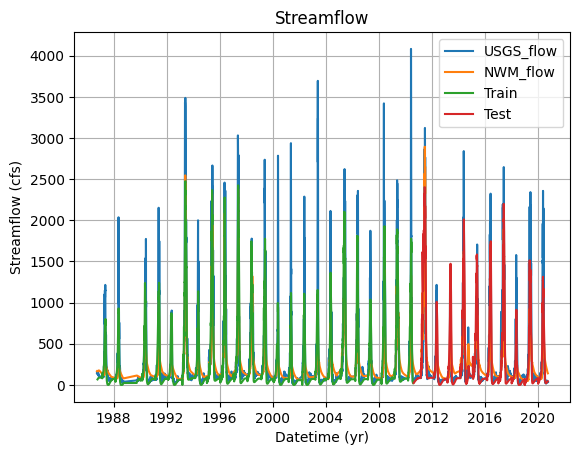

LSTM: NSE 0.7479, RMSE 246.0000, MaxError 1392.0000, MAPE 54.0000, KGE 0.8700 
NWM: NSE 0.0102, RMSE 310.0000, MaxError 3159.0000, MAPE 111.0000, KGE 0.3300 


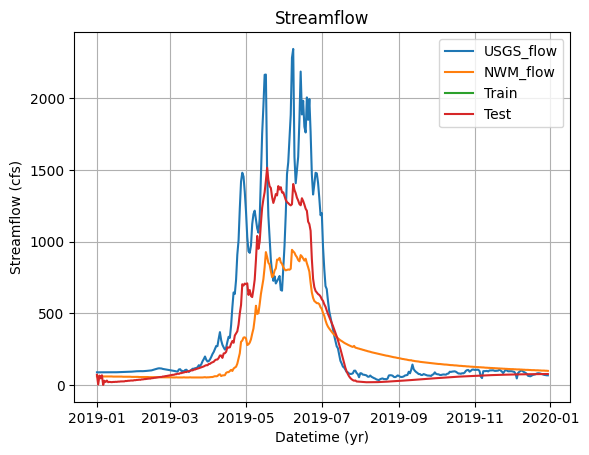

LSTM: NSE 0.6016, RMSE 260.0000, MaxError 1021.0000, MAPE 40.0000, KGE 0.5400 
NWM: NSE -1.3038, RMSE 371.0000, MaxError 1412.0000, MAPE 83.0000, KGE -0.3100 


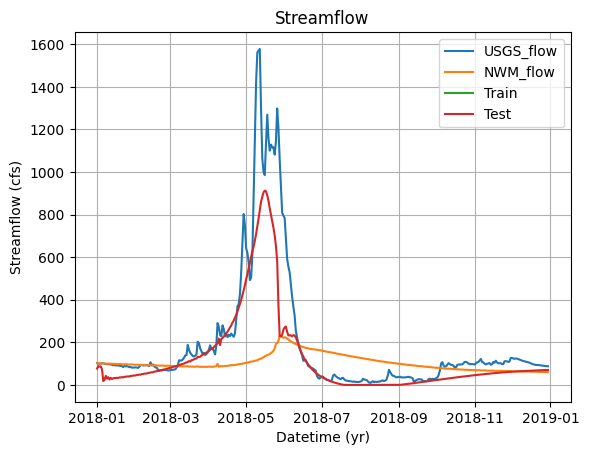

LSTM: NSE 0.3515, RMSE 154.0000, MaxError 834.0000, MAPE 46.0000, KGE 0.2300 
NWM: NSE -60.5084, RMSE 296.0000, MaxError 1456.0000, MAPE 139.0000, KGE -5.9100 


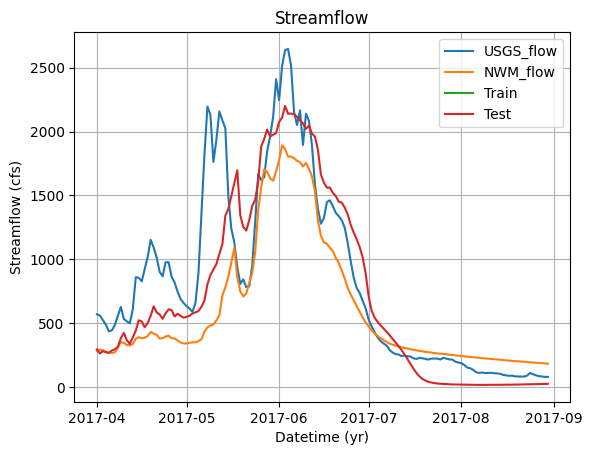

LSTM: NSE 0.7570, RMSE 347.0000, MaxError 1392.0000, MAPE 46.0000, KGE 0.8200 
NWM: NSE 0.1898, RMSE 448.0000, MaxError 1729.0000, MAPE 47.0000, KGE 0.4100 


In [4]:
#Inputs and model parameters to load model
input_size = len(input_columns)
hidden_size = 100 #hidden_size
num_layers = 1 
batchfirst = True 
model_path = 'models/NWM_Multivariate_LSTM/NWM-DOY_model.pt'
y_scaler_path = 'models/NWM_Multivariate_LSTM/NWM-DOY_y_scaler.save'
loss_fn = nn.MSELoss()
cols = ['USGS_flow', 'NWM_flow', 'Train', 'Test']


#load model and make predictions on training and testing datasets
model = Simple_LSTM(input_size, hidden_size, num_layers, batchfirst)
model = LSTM_load(model, model_path)

#Evaluate model
df = model_eval(df,cols, model, y_scaler_path, lookback, X_train, X_test, train_ratio)

#lets take a closer look at the predictions, its a bit difficult to investigate in the above plot
plot(df.loc['2019-1-1':'2019-12-30'], cols)
plot(df.loc['2018-1-1':'2018-12-30'], cols)
plot(df.loc['2017-4-1':'2017-8-30'], cols)

# Lets add another feature to see if it will improve streamflow estimtes from the NWM

In [5]:
#read parquet file from AWS s3 - put in credentials or updated script to not need them
folder = 'RJ/data'
USGSpath = f"{folder}/GSL_NWM_NWIS_dataset.parquet"

df2 = readdata(USGSpath, drop = True)

#change column name for USGS flow
df2.rename(columns={'flow_cfs': 'USGS_flow'}, inplace= True)

#select our site of interest
NWISsite = 10155000
df2 = df2[df2['station_id'] == NWISsite]

#selecting dynamic columns for use as features into the model
cols = ['datetime','DOY', 's1', 's2', 'storage', 'swe', 'NWM_flow', 'USGS_flow']
df2=df2[cols]

#convert datetime to pandas datetime dtype
df2['datetime'] =pd.to_datetime(df2['datetime'])

#sort values and set index to date time
df2.sort_values(by='datetime', inplace=True)
df2.set_index('datetime', inplace=True)

#drop any rows with NaN
df2 = df2.dropna()

df2.head(5)

,DOY,s1,s2,storage,swe,NWM_flow,USGS_flow
datetime,,,,,,,
1986-10-01,274,-0.891007,-0.453991,0.0,1.5,167.0,144.11765
1986-10-02,275,-0.891007,-0.453991,0.0,1.8,166.0,147.25000
1986-10-03,276,-0.891007,-0.453991,0.0,1.7,166.0,154.50000
1986-10-04,277,-0.891007,-0.453991,0.0,1.4,166.0,144.12500
1986-10-05,278,-0.891007,-0.453991,0.0,1.5,165.0,142.50000


In [6]:
#Process DF to input tensors into lstm
#adding one feature at a time to observe changes in model performance
input_columns =['NWM_flow', 'DOY', 's1', 's2']
target = ['USGS_flow']
x_scaler_path = 'models/NWM_Multivariate_LSTM/NWM-DOY-s1s2_x_scaler.save'
y_scaler_path = 'models/NWM_Multivariate_LSTM/NWM-DOY-s1s2_y_scaler.save'
lookback = 15
train_ratio = 0.67

#split data into train/test - note, for LSTM there is not need to randomize the split
#run data processing function (df, input_columns, target, lookback, trainsize)
X_train, X_test, y_train, y_test = Multivariate_DataProcessing(df2, input_columns, target, lookback, train_ratio, x_scaler_path, y_scaler_path)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([6441, 15, 4]) torch.Size([6441])
torch.Size([3165, 15, 4]) torch.Size([3165])


In [9]:
#Inputs and model parameters
#Inputs and model parameters
input_size = len(input_columns) #the number of expected feaures in the input x
hidden_size = 100 # the number of features in the hidden state 
num_layers = 1 #the number of recurrent layers. E.g., setting to 2 means stacking 2 LSTMS together to form a stacked LSTM with the second taking the outputs from the first
batch_size = 20 #Typically set the batch size to loop through 64-128 samples at a time - it looks the model likes small batches to train on
batchfirst = True #if True, the the input and output tensors are (batch, seq, feature) instead of (seq, batch, feature)
n_epochs = 50 # Make sure there are enough epochs to ensure model convergence, excess epochs will just increase training time. . 
save_model = True
test_score = True
model_path = 'models/NWM_Multivariate_LSTM/NWM-DOY-s1s2_model.pt'

#Load model class
model = Simple_LSTM(input_size, hidden_size, num_layers, batchfirst)
#connect to GPU device - will default to cpu if there is no GPU available
model.to(DEVICE)
# set optimizer
optimizer = optim.Adam(model.parameters())
#set loss function
loss_fn = nn.MSELoss()
#set dataloader function
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle= False, batch_size=batch_size) #make sure shuffle is set to false for LSTM

#set configurations dictionary
config_dict = {
            'X_train': X_train, 
            'y_train' : y_train,
            'X_test': X_test,
            'y_test': y_test,
            'n_epochs': n_epochs,
            'model': model, 
            'loader': loader, 
            'optimizer': optimizer, 
            'loss_fn': loss_fn, 
            'save_model': save_model, 
            'model_path': model_path, 
            'test_score': test_score,
}


#Train the LSTM
train_LSTM(config_dict)


Epoch 0: train RMSE 1.2373, test RMSE 1.2352
Epoch 10: train RMSE 1.3378, test RMSE 1.3349
Epoch 20: train RMSE 1.3407, test RMSE 1.3310
Epoch 30: train RMSE 1.3358, test RMSE 1.3237
Epoch 40: train RMSE 1.3346, test RMSE 1.3228
Model training took: 34.7979464  seconds
Model training complete, model saved as models/NWM_Multivariate_LSTM/NWM-DOY-s1s2_model.pt


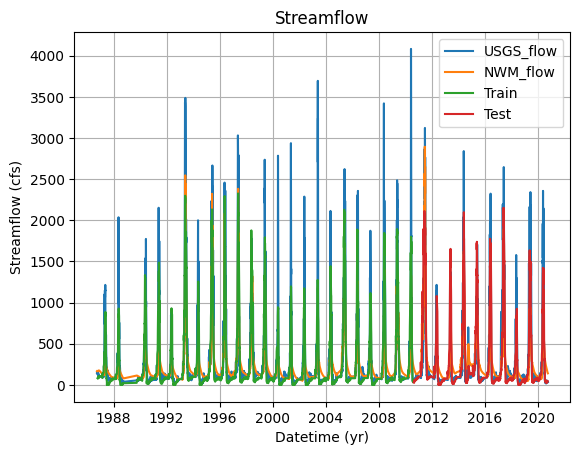

LSTM: NSE 0.7350, RMSE 249.0000, MaxError 1385.0000, MAPE 51.0000, KGE 0.8600 
NWM: NSE 0.0102, RMSE 310.0000, MaxError 3159.0000, MAPE 111.0000, KGE 0.3300 


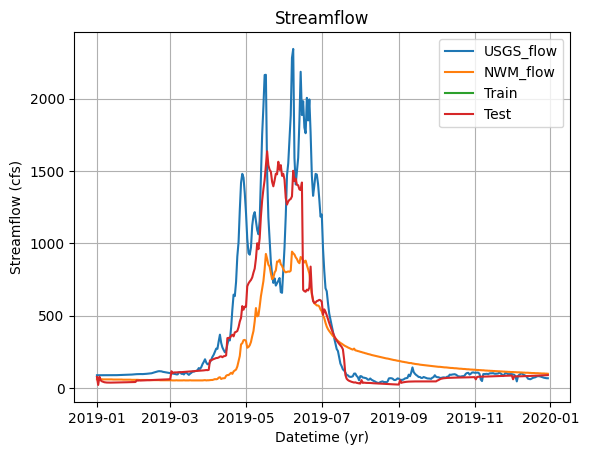

LSTM: NSE 0.4756, RMSE 302.0000, MaxError 1326.0000, MAPE 35.0000, KGE 0.5600 
NWM: NSE -1.3038, RMSE 371.0000, MaxError 1412.0000, MAPE 83.0000, KGE -0.3100 


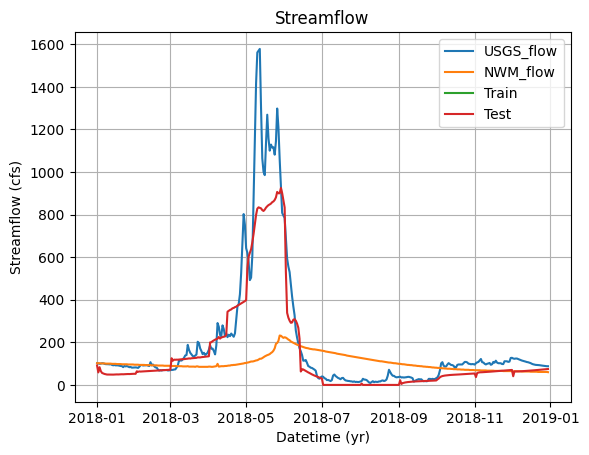

LSTM: NSE 0.7352, RMSE 115.0000, MaxError 747.0000, MAPE 44.0000, KGE 0.5400 
NWM: NSE -60.5084, RMSE 296.0000, MaxError 1456.0000, MAPE 139.0000, KGE -5.9100 


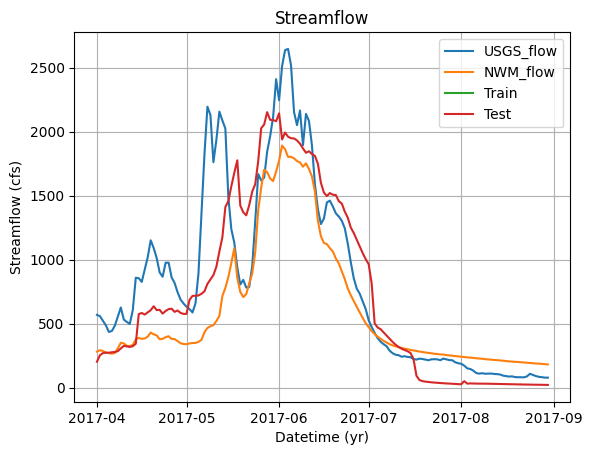

LSTM: NSE 0.7284, RMSE 360.0000, MaxError 1385.0000, MAPE 45.0000, KGE 0.8200 
NWM: NSE 0.1898, RMSE 448.0000, MaxError 1729.0000, MAPE 47.0000, KGE 0.4100 


In [7]:
#Inputs and model parameters to load model
input_size = len(input_columns)
hidden_size = 100 #hidden_size
num_layers = 1 
batchfirst = True 
model_path = 'models/NWM_Multivariate_LSTM/NWM-DOY-s1s2_model.pt'
y_scaler_path = 'models/NWM_Multivariate_LSTM/NWM-DOY-s1s2_y_scaler.save'
loss_fn = nn.MSELoss()
cols = ['USGS_flow', 'NWM_flow', 'Train', 'Test']


#load model and make predictions on training and testing datasets
model = Simple_LSTM(input_size, hidden_size, num_layers, batchfirst)
model = LSTM_load(model, model_path)

#Evaluate model
df2 = model_eval(df2,cols, model, y_scaler_path, lookback, X_train, X_test, train_ratio)

#lets take a closer look at the predictions, its a bit difficult to investigate in the above plot
plot(df2.loc['2019-1-1':'2019-12-30'], cols)
plot(df2.loc['2018-1-1':'2018-12-30'], cols)
plot(df2.loc['2017-4-1':'2017-8-30'], cols)

# Lets add all of the dynamic features
We will use the catchment characteristics when we start adding more locations into the model

In [8]:
#read parquet file from AWS s3 - put in credentials or updated script to not need them
folder = 'RJ/data'
USGSpath = f"{folder}/GSL_NWM_NWIS_dataset.parquet"

df3 = readdata(USGSpath, drop = True)

#change column name for USGS flow
df3.rename(columns={'flow_cfs': 'USGS_flow'}, inplace= True)

#select our site of interest
NWISsite = 10155000
df3 = df3[df3['station_id'] == NWISsite]

#selecting dynamic columns for use as features into the model
cols = ['datetime','DOY', 's1', 's2', 'storage', 'swe', 'NWM_flow', 'USGS_flow']
df3=df3[cols]

#convert datetime to pandas datetime dtype
df3['datetime'] =pd.to_datetime(df3['datetime'])

#sort values and set index to date time
df3.sort_values(by='datetime', inplace=True)
df3.set_index('datetime', inplace=True)

#drop any rows with NaN
df3 = df3.dropna()

df3.head(5)

,DOY,s1,s2,storage,swe,NWM_flow,USGS_flow
datetime,,,,,,,
1986-10-01,274,-0.891007,-0.453991,0.0,1.5,167.0,144.11765
1986-10-02,275,-0.891007,-0.453991,0.0,1.8,166.0,147.25000
1986-10-03,276,-0.891007,-0.453991,0.0,1.7,166.0,154.50000
1986-10-04,277,-0.891007,-0.453991,0.0,1.4,166.0,144.12500
1986-10-05,278,-0.891007,-0.453991,0.0,1.5,165.0,142.50000


In [9]:
#Process DF to input tensors into lstm
#adding one feature at a time to observe changes in model performance
input_columns =['NWM_flow', 'DOY', 's1', 's2', 'storage', 'swe'] #the storage metric looks off...
target = ['USGS_flow']
x_scaler_path = 'models/NWM_Multivariate_LSTM/NWM-DOY-s1s2-swe-storage_x_scaler.save'
y_scaler_path = 'models/NWM_Multivariate_LSTM/NWM-DOY-s1s2-swe-storage_y_scaler.save'
lookback = 15
train_ratio = 0.67

#split data into train/test - note, for LSTM there is not need to randomize the split
#run data processing function (df, input_columns, target, lookback, trainsize)
X_train, X_test, y_train, y_test = Multivariate_DataProcessing(df3, input_columns, target, lookback, train_ratio, x_scaler_path, y_scaler_path)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([6441, 15, 6]) torch.Size([6441])
torch.Size([3165, 15, 6]) torch.Size([3165])


In [14]:
#Inputs and model parameters
#Inputs and model parameters
input_size = len(input_columns) #the number of expected feaures in the input x
hidden_size = 100 # the number of features in the hidden state 
num_layers = 1 #the number of recurrent layers. E.g., setting to 2 means stacking 2 LSTMS together to form a stacked LSTM with the second taking the outputs from the first
batch_size = 20 #Typically set the batch size to loop through 64-128 samples at a time - it looks the model likes small batches to train on
batchfirst = True #if True, the the input and output tensors are (batch, seq, feature) instead of (seq, batch, feature)
n_epochs = 50 # Make sure there are enough epochs to ensure model convergence, excess epochs will just increase training time. . 
save_model = True
test_score = True
model_path = 'models/NWM_Multivariate_LSTM/NWM-DOY-s1s2-swe-storage_model.pt'

#Load model class
model = Simple_LSTM(input_size, hidden_size, num_layers, batchfirst)
#connect to GPU device - will default to cpu if there is no GPU available
model.to(DEVICE)
# set optimizer
optimizer = optim.Adam(model.parameters())
#set loss function
loss_fn = nn.MSELoss()
#set dataloader function
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle= False, batch_size=batch_size) #make sure shuffle is set to false for LSTM

#set configurations dictionary
config_dict = {
            'X_train': X_train, 
            'y_train' : y_train,
            'X_test': X_test,
            'y_test': y_test,
            'n_epochs': n_epochs,
            'model': model, 
            'loader': loader, 
            'optimizer': optimizer, 
            'loss_fn': loss_fn, 
            'save_model': save_model, 
            'model_path': model_path, 
            'test_score': test_score,
}


#Train the LSTM
train_LSTM(config_dict)


Epoch 0: train RMSE 1.2905, test RMSE 1.2902
Epoch 10: train RMSE 1.3469, test RMSE 1.3328
Epoch 20: train RMSE 1.3372, test RMSE 1.3217
Epoch 30: train RMSE 1.3326, test RMSE 1.3124
Epoch 40: train RMSE 1.3302, test RMSE 1.3068
Model training took: 34.92514729999999  seconds
Model training complete, model saved as models/NWM_Multivariate_LSTM/NWM-DOY-s1s2-swe-storage_model.pt


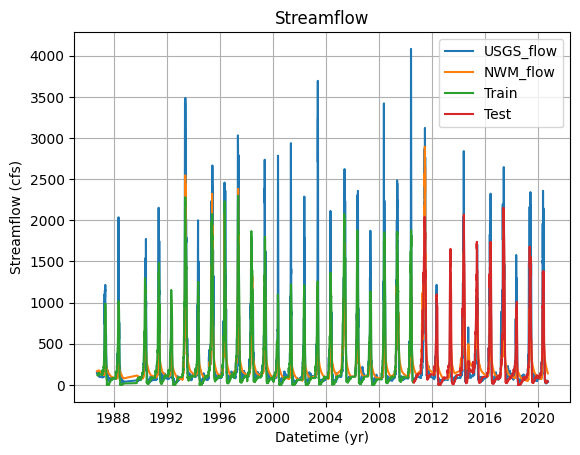

LSTM: NSE 0.7451, RMSE 236.0000, MaxError 1373.0000, MAPE 50.0000, KGE 0.8600 
NWM: NSE 0.0102, RMSE 310.0000, MaxError 3159.0000, MAPE 111.0000, KGE 0.3300 


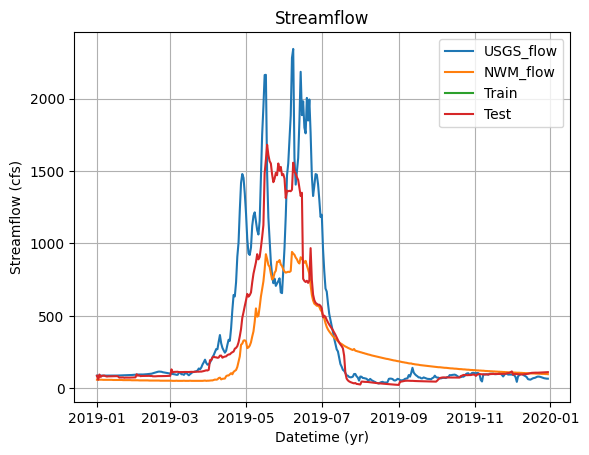

LSTM: NSE 0.4533, RMSE 306.0000, MaxError 1262.0000, MAPE 29.0000, KGE 0.5700 
NWM: NSE -1.3038, RMSE 371.0000, MaxError 1412.0000, MAPE 83.0000, KGE -0.3100 


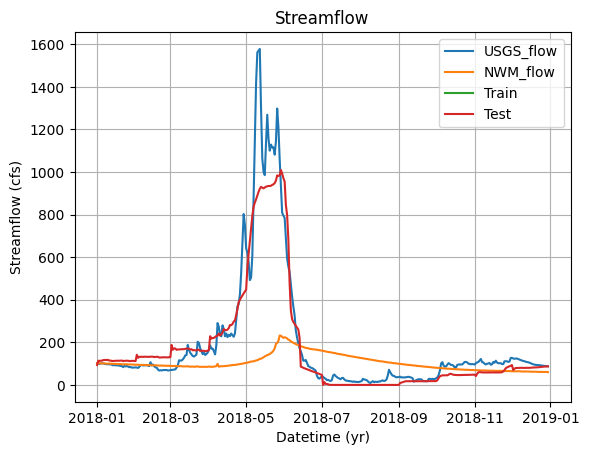

LSTM: NSE 0.8422, RMSE 99.0000, MaxError 672.0000, MAPE 45.0000, KGE 0.7700 
NWM: NSE -60.5084, RMSE 296.0000, MaxError 1456.0000, MAPE 139.0000, KGE -5.9100 


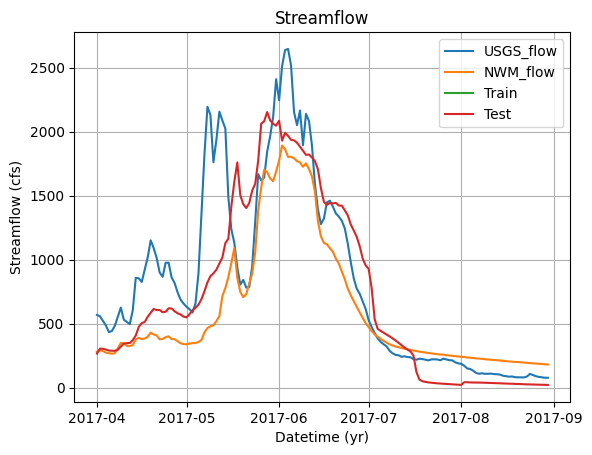

LSTM: NSE 0.7018, RMSE 370.0000, MaxError 1373.0000, MAPE 44.0000, KGE 0.8000 
NWM: NSE 0.1898, RMSE 448.0000, MaxError 1729.0000, MAPE 47.0000, KGE 0.4100 


In [10]:
#Inputs and model parameters to load model
input_size = len(input_columns)
hidden_size = 100 #hidden_size
num_layers = 1 
batchfirst = True 
model_path = 'models/NWM_Multivariate_LSTM/NWM-DOY-s1s2-swe-storage_model.pt'
y_scaler_path = 'models/NWM_Multivariate_LSTM/NWM-DOY-s1s2-swe-storage_y_scaler.save'
loss_fn = nn.MSELoss()
cols = ['USGS_flow', 'NWM_flow', 'Train', 'Test']


#load model and make predictions on training and testing datasets
model = Simple_LSTM(input_size, hidden_size, num_layers, batchfirst)
model = LSTM_load(model, model_path)

#Evaluate model
df3 = model_eval(df3,cols, model, y_scaler_path, lookback, X_train, X_test, train_ratio)

#lets take a closer look at the predictions, its a bit difficult to investigate in the above plot
plot(df3.loc['2019-1-1':'2019-12-30'], cols)
plot(df3.loc['2018-1-1':'2018-12-30'], cols)
plot(df3.loc['2017-4-1':'2017-8-30'], cols)

# Compare models
Lets see if adding more features affected model performance

In [11]:
import numpy as np

cols = ['USGS_flow', 'NWM_flow', 'Test']

dfs = [df, df2, df3]
for i in np.arange(0, len(dfs),1):
    dfs[i] = dfs[i][cols].dropna()
    colnam = f"Test_{i}"
    dfs[i].rename(columns = {'Test': colnam}, inplace = True)

Eval_df = pd.concat(dfs, axis=1)
Eval_df = Eval_df.loc[:,~Eval_df.columns.duplicated()].copy()
Eval_df.head()

,USGS_flow,NWM_flow,Test_0,Test_1,Test_2
datetime,,,,,
2010-08-20,57.723957,212.0,23.438787,29.925604,33.709080
2010-08-21,54.814583,210.0,23.917761,29.494024,32.927494
2010-08-22,52.836456,208.0,24.412573,28.987555,32.159031
2010-08-23,56.767708,206.0,24.898413,28.472174,31.383184
2010-08-24,61.966667,205.0,25.386114,27.963263,30.616980


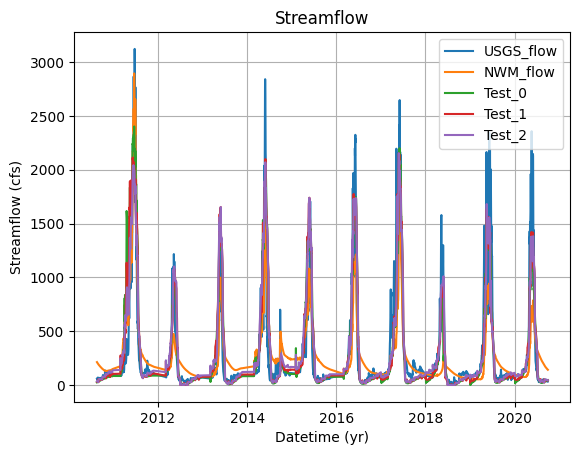

NWM_flow : NSE 0.3233, RMSE 283.0000, MaxError 1729.0000, MAPE 125.0000, KGE 0.5400 
Test_0 : NSE 0.7479, RMSE 246.0000, MaxError 1392.0000, MAPE 54.0000, KGE 0.8700 
Test_1 : NSE 0.7350, RMSE 249.0000, MaxError 1385.0000, MAPE 51.0000, KGE 0.8600 
Test_2 : NSE 0.7451, RMSE 236.0000, MaxError 1373.0000, MAPE 50.0000, KGE 0.8600 


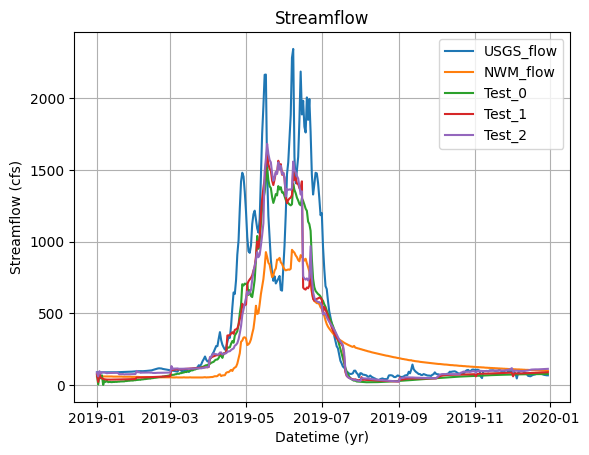

NWM_flow : NSE -1.3038, RMSE 371.0000, MaxError 1412.0000, MAPE 83.0000, KGE -0.3100 
Test_0 : NSE 0.6016, RMSE 260.0000, MaxError 1021.0000, MAPE 40.0000, KGE 0.5400 
Test_1 : NSE 0.4756, RMSE 302.0000, MaxError 1326.0000, MAPE 35.0000, KGE 0.5600 
Test_2 : NSE 0.4533, RMSE 306.0000, MaxError 1262.0000, MAPE 29.0000, KGE 0.5700 


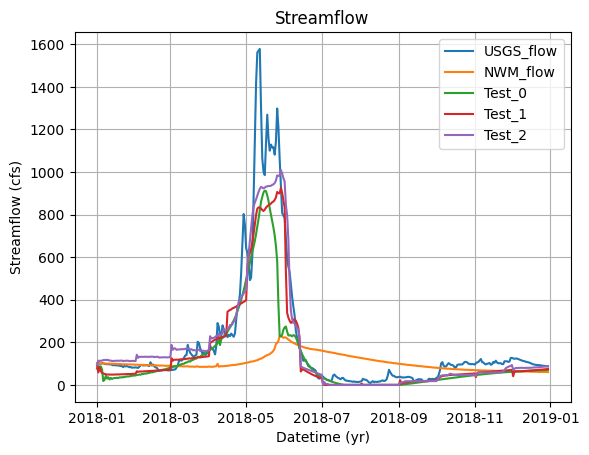

NWM_flow : NSE -60.5084, RMSE 296.0000, MaxError 1456.0000, MAPE 139.0000, KGE -5.9100 
Test_0 : NSE 0.3515, RMSE 154.0000, MaxError 834.0000, MAPE 46.0000, KGE 0.2300 
Test_1 : NSE 0.7352, RMSE 115.0000, MaxError 747.0000, MAPE 44.0000, KGE 0.5400 
Test_2 : NSE 0.8422, RMSE 99.0000, MaxError 672.0000, MAPE 45.0000, KGE 0.7700 


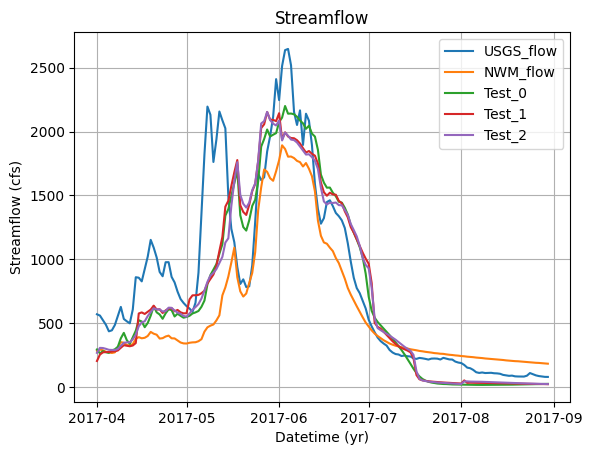

NWM_flow : NSE 0.1898, RMSE 448.0000, MaxError 1729.0000, MAPE 47.0000, KGE 0.4100 
Test_0 : NSE 0.7570, RMSE 347.0000, MaxError 1392.0000, MAPE 46.0000, KGE 0.8200 
Test_1 : NSE 0.7284, RMSE 360.0000, MaxError 1385.0000, MAPE 45.0000, KGE 0.8200 
Test_2 : NSE 0.7018, RMSE 370.0000, MaxError 1373.0000, MAPE 44.0000, KGE 0.8000 


In [12]:
cols = ['USGS_flow', 'NWM_flow', 'Test_0', 'Test_1', 'Test_2']
Models_Eval_plot(Eval_df, cols)

#lets take a closer look at the predictions, its a bit difficult to investigate in the above plot
Models_Eval_plot(Eval_df.loc['2019-1-1':'2019-12-30'], cols)
Models_Eval_plot(Eval_df.loc['2018-1-1':'2018-12-30'], cols)
Models_Eval_plot(Eval_df.loc['2017-4-1':'2017-8-30'], cols)